# Оцениваем регрессии на данных HS0 в спецификациях:
- Фиксированные эффекты ~ ковид и ограничения
- Фиксированные эффекты ~ ковид и ограничения | инструментальные переменные
- В перспективе: суммарный экспорт/импорт в зависимости от ковида (+ IV)

In [213]:
library(arrow)
library(stargazer)
library(tidyverse)
library(plotly)
library(fixest)

## Фиксированные эффекты

### Экспорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [214]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_export_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,-3.339168,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,7.347834,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,-5.962379,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,1.653766,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,-14.478386,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,13.013159,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


### Рисую обычный и demeaned scatterplot, чтобы обосновать необходимость использования фиксированных эффектов

Графики будут интерактивные, если раскомментить ggplotly, закомментить p и перепрогнать

Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`)."


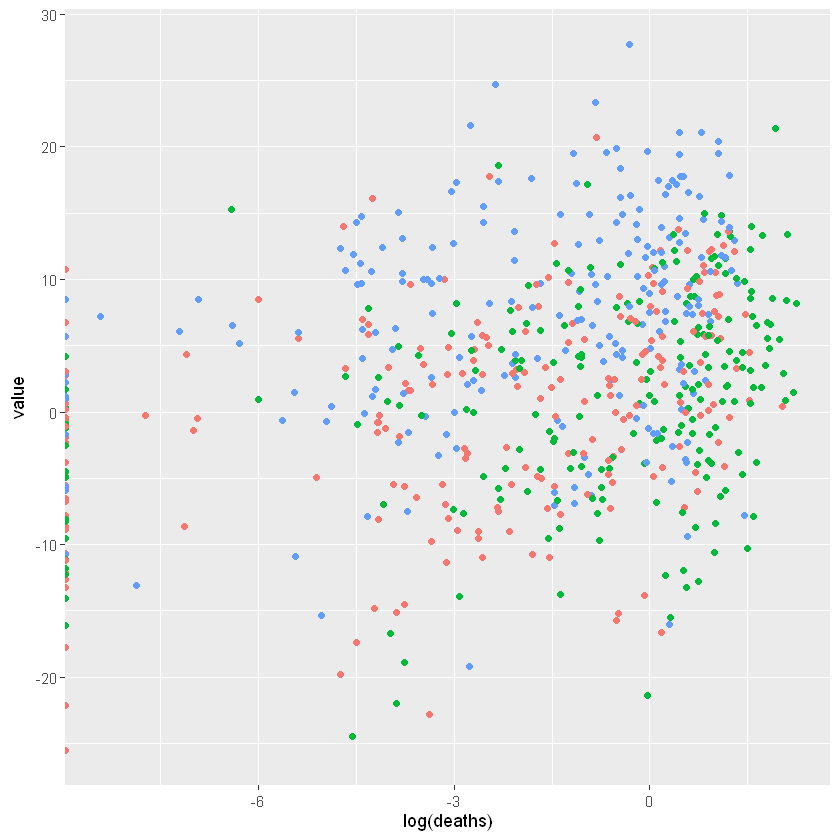

In [215]:
p = ggplot(df, aes(x = log(deaths), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p) 
p   

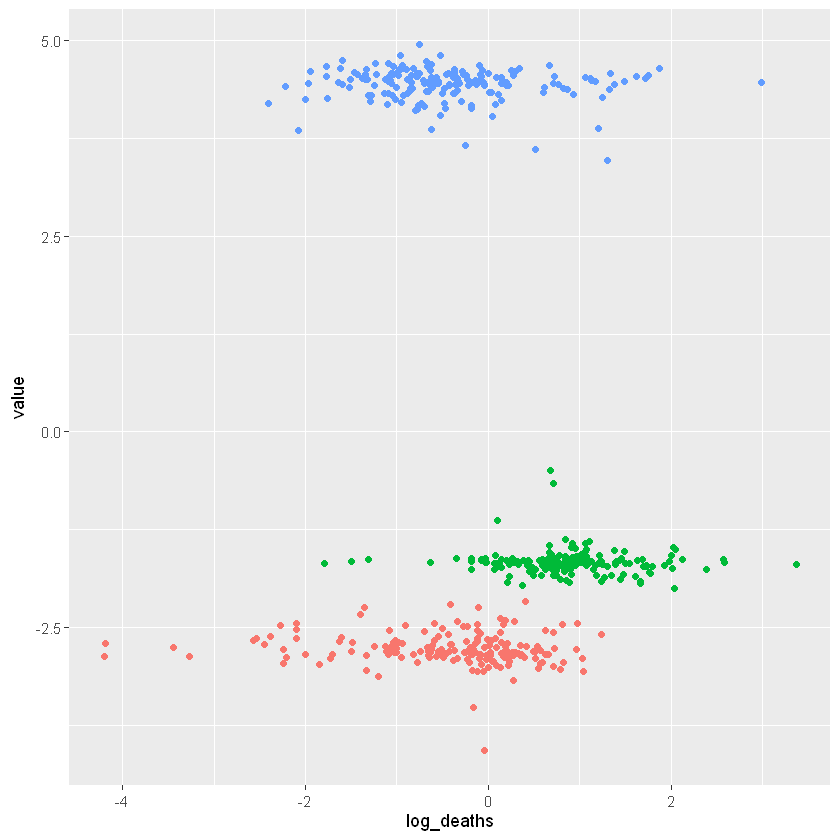

In [216]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log(deaths), na.rm = TRUE))  %>% filter(avg_log_deaths > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_deaths = log(deaths)- avg_log_deaths, value = value- avg_value) %>%
   select(country, year, log_deaths, value)
p = ggplot(demeaned_df, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

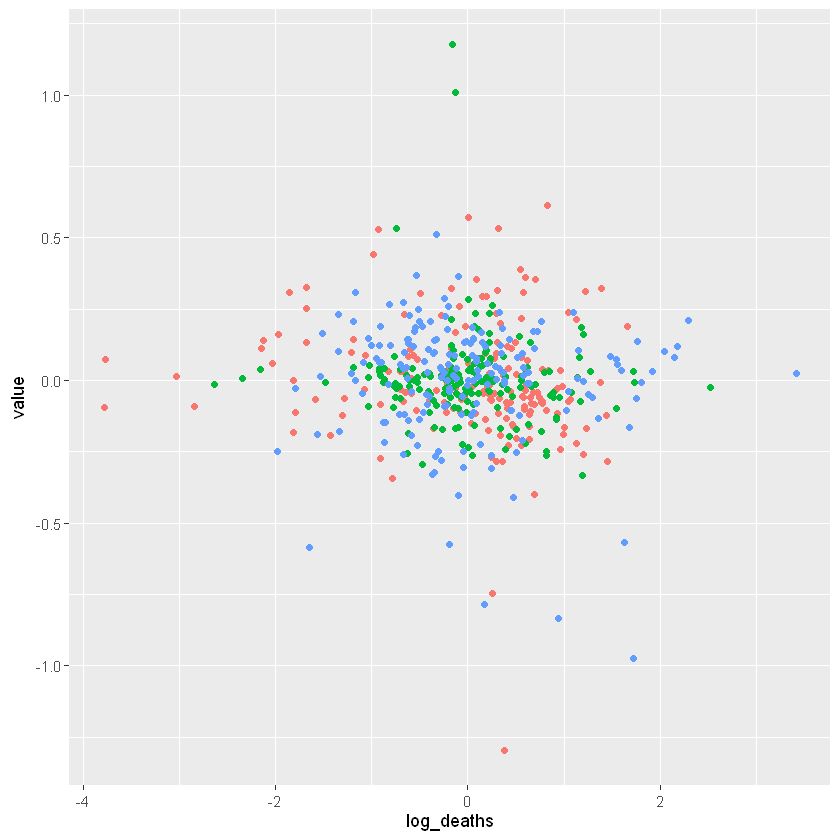

In [217]:
year_means_df = demeaned_df %>% filter(log_deaths > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log_deaths, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_deaths = log_deaths- avg_log_deaths, value = value - avg_value) %>%
   select(country, year, log_deaths, value)

p = ggplot(demeaned_df2, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

In [218]:
year_means_df

year,avg_value,avg_log_deaths
<chr>,<dbl>,<dbl>
2020,-2.772960,-0.4175810
2021,-1.664875,0.8439503
2022,4.437835,-0.4263693


### Сами регрессии

In [219]:
# Pulled OLS
export_m0 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| year,
 data = df)
export_m0 %>% summary(vcov = ~country)

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                                   Estimate Std. Error  t value   Pr(>|t|)    
log(deaths)                        1.137831   0.268169 4.242957 3.5795e-05 ***
C8EV_International_travel_controls 0.250616   0.640685 0.391168 6.9615e-01    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.3561     Adj. R2: 0.207405
               Within R2: 0.091339

In [220]:
export_m1 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country + year,
 data = df)
export_m1 %>% summary(vcov = ~country)

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error  t value Pr(>|t|)    
log(deaths)                        -0.011189   0.010797 -1.03637 0.301469    
C8EV_International_travel_controls -0.060563   0.028621 -2.11604 0.035764 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.164813     Adj. R2: 0.99939 
                 Within R2: 0.020382

In [221]:
# Маски сами по себе --- слабый и эндогенный (= плохой) инструмент
# Зато другие хорошие
export_m1_iv = feols(value ~ 1 + C8EV_International_travel_controls|country + year|
 log(deaths) ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
export_m1_iv %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (RHS: 126, IV: 74/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 504
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|)    
fit_log(deaths)                    -0.027274   0.040390 -0.675269 0.500401    
C8EV_International_travel_controls -0.068952   0.030996 -2.224567 0.027396 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.165544     Adj. R2: 0.999383
                 Within R2: 0.014292
F-test (1st stage), log(deaths): stat = 14.3     , p = 6.098e-9, on 3 and 497 DoF.
                     Wu-Hausman: stat =  0.180157, p = 0.67152 , on 1 and 324 DoF.
                         Sargan: stat =  4.17049 , p = 0.124277, on 2 DoF.

In [222]:
# Гетерогенность во времени
export_m2 = feols(value ~ year/log(deaths) + year/C8EV_International_travel_controls| country,
 data = df)
export_m2 %>% summary(vcov = ~country)

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                             Estimate Std. Error   t value
year2021                                     1.022158   0.088291 11.577136
year2022                                     7.073336   0.101788 69.491178
year2020:log(deaths)                        -0.022881   0.012000 -1.906742
year2021:log(deaths)                        -0.016422   0.012414 -1.322804
year2022:log(deaths)                        -0.002128   0.013705 -0.155286
year2020:C8EV_International_travel_controls -0.091384   0.042503 -2.150051
year2021:C8EV_International_travel_controls -0.045326   0.030397 -1.491127
year2022:C8EV_International_travel_controls -0.029126   0.058872 -0.494737
                                             Pr(>|t|)    
year2021                                    < 2.2e-16 ***
year2022                                    < 2.2e-16 ***
year2020:log(deaths)              

In [223]:
# Здесь это точно не осмысленно использовать кластеризацию по годам.
# С кластеризацией по странам есть значимость только у ограничений на поездки. 
# На инструменты пока смотреть не стоит, потому что они слабые.
etable(export_m0, export_m1, export_m1_iv, export_m2, vcov = ~country)

,,export_m0,export_m1,export_m1_iv,export_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(deaths),1.138*** (0.2682),-0.0112 (0.0108),-0.0273 (0.0404),
4,C8EV_International_travel_controls,0.2506 (0.6407),-0.0606* (0.0286),-0.0689* (0.0310),
5,year2021,,,,1.022*** (0.0883)
6,year2022,,,,7.073*** (0.1018)
7,year2020 x log(deaths),,,,-0.0229. (0.0120)
8,year2021 x log(deaths),,,,-0.0164 (0.0124)
9,year2022 x log(deaths),,,,-0.0021 (0.0137)


In [224]:
# С НАС ничего не значимо
etable(export_m0, export_m1, export_m1_iv, export_m2, vcov = vcov_NW(unit = 'country', time = 'year'))

,,export_m0,export_m1,export_m1_iv,export_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(deaths),1.138* (0.2576),-0.0112 (0.0107),-0.0273 (0.0421),
4,C8EV_International_travel_controls,0.2506 (0.7239),-0.0606 (0.0315),-0.0689 (0.0327),
5,year2021,,,,1.022** (0.0909)
6,year2022,,,,7.073*** (0.0985)
7,year2020 x log(deaths),,,,-0.0229 (0.0117)
8,year2021 x log(deaths),,,,-0.0164 (0.0138)
9,year2022 x log(deaths),,,,-0.0021 (0.0133)


In [225]:
# Реплицирую (Berthou, 2024), но результат не сходится, если использовать ошибки НАС
m = feols(value ~ StringencyIndex_Average | country + year,
 data = df)
m %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))
m %>% summary(vcov = ~country)

NOTE: 126 observations removed because of NA values (RHS: 126).



OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Newey-West (L=1) 
                         Estimate Std. Error  t value Pr(>|t|) 
StringencyIndex_Average -0.003248   0.001156 -2.80962  0.10677 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.16986     Adj. R2: 0.999378
                Within R2: 0.020902

OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error  t value  Pr(>|t|)    
StringencyIndex_Average -0.003248   0.001159 -2.80255 0.0056352 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.16986     Adj. R2: 0.999378
                Within R2: 0.020902

### Импорт

In [226]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_import_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,5.593365,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,11.366298,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,-4.466964,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,-1.079447,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,11.645198,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,-10.549667,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


In [227]:
# Реплицирую (Berthou, 2024), но результат совсем не сходится...
m = feols(value ~ StringencyIndex_Average | country + year,
 data = df)
m %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))
m %>% summary(vcov = ~country)

NOTE: 126 observations removed because of NA values (RHS: 126).



OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Newey-West (L=1) 
                         Estimate Std. Error  t value Pr(>|t|) 
StringencyIndex_Average -0.002699   0.001079 -2.50267  0.12939 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141099     Adj. R2: 0.999541
                 Within R2: 0.020914

OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error  t value Pr(>|t|)    
StringencyIndex_Average -0.002699   0.001101 -2.45075 0.015228 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141099     Adj. R2: 0.999541
                 Within R2: 0.020914

### Обосновываю включение фиксированных эффектов

In [228]:
fixest::demean(df[, c('deaths', 'value')], df[, c('country', 'year')]) %>% head()

NOTE: 6 observations removed because of NA values (Breakup: X: 6, f: 0).



deaths,value
<dbl>,<dbl>
0.3276217,-0.17822285
1.6103933,-0.21494329
0.7609018,-0.05014374
0.3851169,0.10634113
-0.2756432,0.21114565
-0.2838225,0.14120842


Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`)."


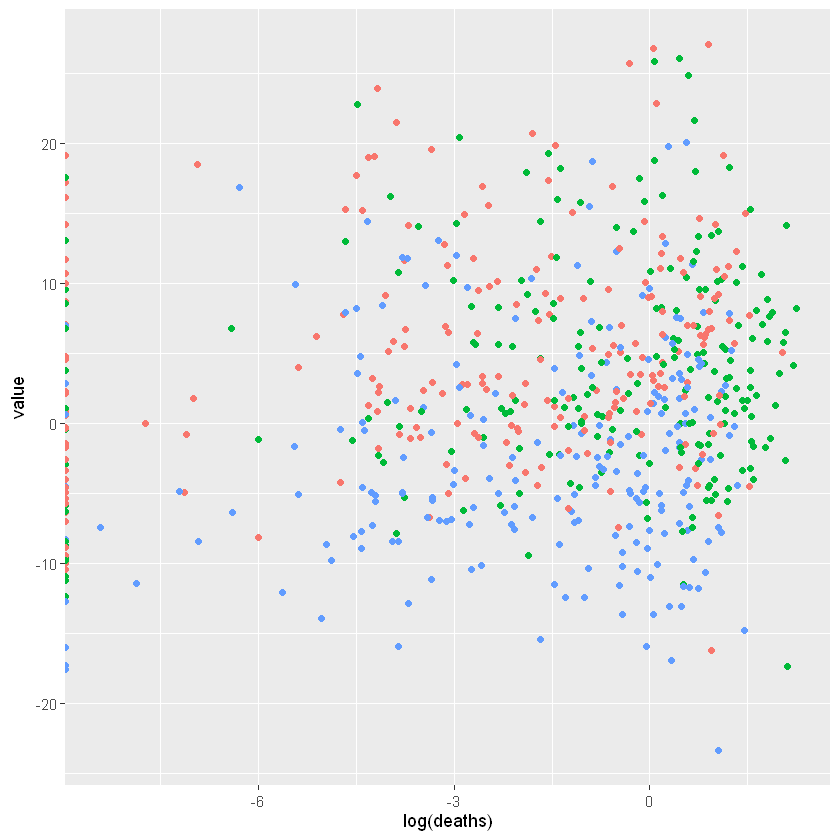

In [229]:
p = ggplot(df, aes(x = log(deaths), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)   
p 

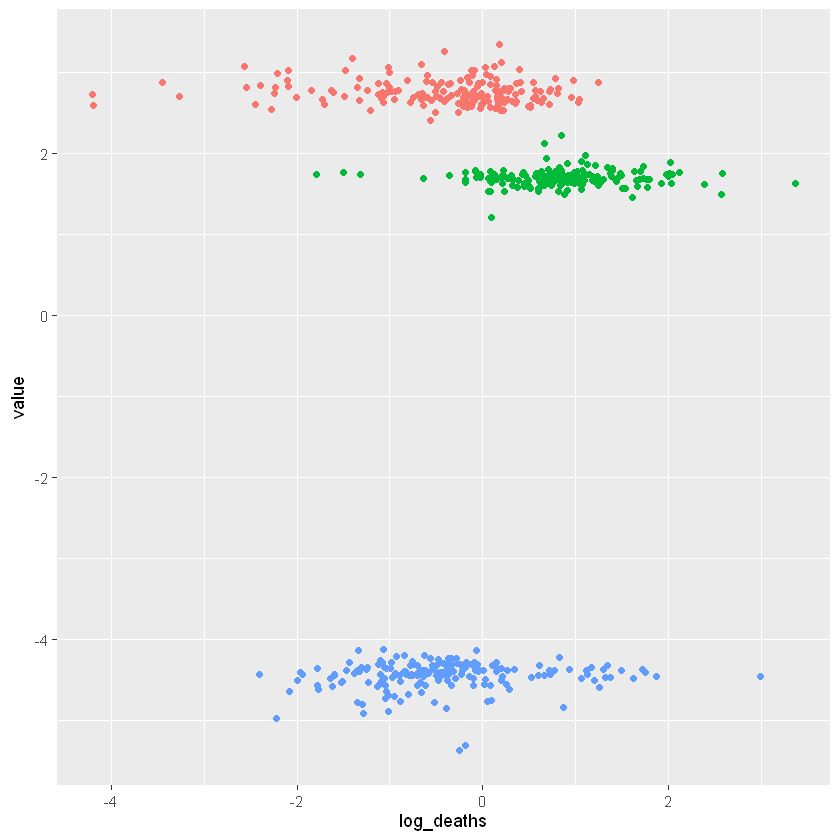

In [230]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log(deaths), na.rm = TRUE))  %>% filter(avg_log_deaths > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_deaths = log(deaths)- avg_log_deaths, value = value- avg_value) %>%
   select(country, year, log_deaths, value)
p = ggplot(demeaned_df, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)  
p  

In [231]:
year_means_df

year,avg_value,avg_log_deaths
<chr>,<dbl>,<dbl>
2020,-2.772960,-0.4175810
2021,-1.664875,0.8439503
2022,4.437835,-0.4263693


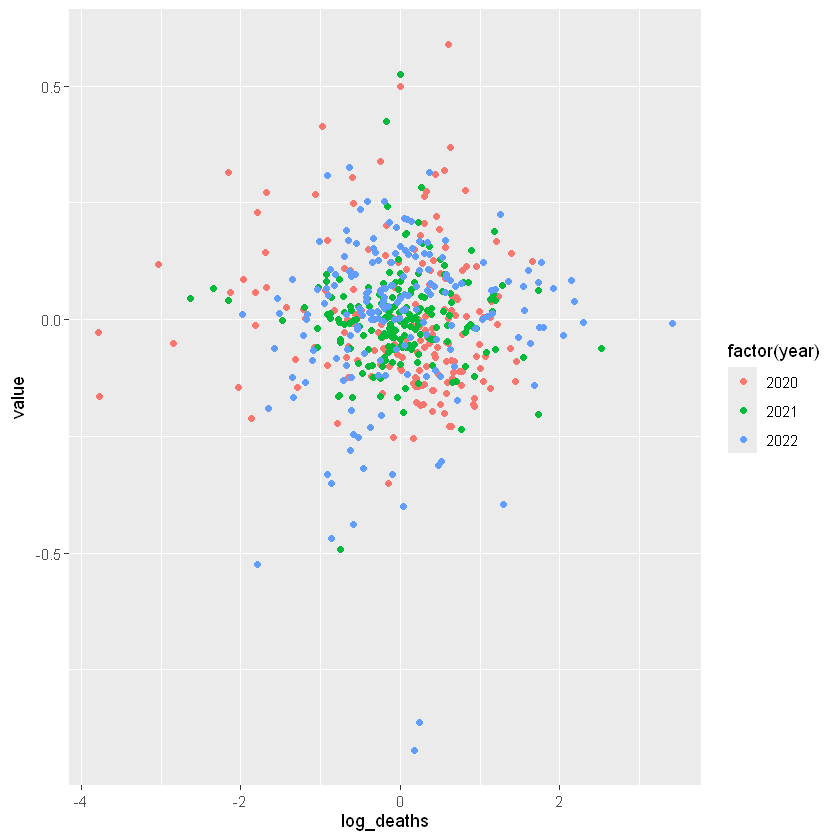

In [232]:
year_means_df = demeaned_df %>% filter(log_deaths > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log_deaths, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_deaths = log_deaths- avg_log_deaths, value = value - avg_value) %>%
   select(country, year, log_deaths, value)

p = ggplot(demeaned_df2, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()#+ theme(legend.position = "none")
# ggplotly(p)   
p 

### Сами регрессии

In [233]:
# Pulled OLS
import_m0 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| year,
 data = df)
import_m0 %>% summary(vcov = ~country)

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                                   Estimate Std. Error  t value Pr(>|t|) 
log(deaths)                        0.149162   0.273552 0.545279  0.58626 
C8EV_International_travel_controls 0.692519   0.783283 0.884124  0.37785 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.41518     Adj. R2: 0.159473
                Within R2: 0.004412

In [234]:
import_m1 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country + year,
 data = df)
import_m1 %>% summary(vcov = ~country)

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|) 
log(deaths)                        -0.001126   0.008672 -0.129851  0.89683 
C8EV_International_travel_controls -0.032537   0.020833 -1.561786  0.12016 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141505     Adj. R2: 0.999531
                 Within R2: 0.008014

In [ ]:

import_m1_iv = feols(value ~ 1 +
 C8EV_International_travel_controls|country + year|
 log(deaths) ~  C1M_School_closing+median_age+population_density,
 data = df)
import_m1_iv %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (RHS: 126, IV: 74/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 504
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)                     0.006351   0.040036  0.158641  0.87414 
C8EV_International_travel_controls -0.028884   0.022614 -1.277251  0.20322 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141853     Adj. R2: 0.999526
                 Within R2: 0.005951
F-test (1st stage), log(deaths): stat = 14.3     , p = 6.098e-9, on 3 and 497 DoF.
                     Wu-Hausman: stat =  0.052585, p = 0.818769, on 1 and 324 DoF.
                         Sargan: stat =  0.403104, p = 0.817461, on 2 DoF.

In [236]:
# Гетерогенность во времени
import_m2 = feols(value ~ year/log(deaths) + year/C8EV_International_travel_controls| country,
 data = df)
import_m2 %>% summary(vcov = ~country)

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                             Estimate Std. Error    t value
year2021                                    -1.126174   0.080742 -13.947839
year2022                                    -7.154620   0.098653 -72.523242
year2020:log(deaths)                        -0.020088   0.010659  -1.884583
year2021:log(deaths)                         0.005541   0.010508   0.527290
year2022:log(deaths)                         0.015720   0.011056   1.421793
year2020:C8EV_International_travel_controls -0.030939   0.035794  -0.864373
year2021:C8EV_International_travel_controls  0.009248   0.016513   0.560043
year2022:C8EV_International_travel_controls -0.090944   0.076861  -1.183225
                                             Pr(>|t|)    
year2021                                    < 2.2e-16 ***
year2022                                    < 2.2e-16 ***
year2020:log(deaths)     

In [ ]:
# Для импортёра вообще ничто не значимо.
etable(import_m0, import_m1, import_m1_iv, import_m2, vcov = ~country)

,,import_m0,import_m1,import_m1_iv,import_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(deaths),0.1492 (0.2736),-0.0011 (0.0087),0.0064 (0.0400),
4,C8EV_International_travel_controls,0.6925 (0.7833),-0.0325 (0.0208),-0.0289 (0.0226),
5,year2021,,,,-1.126*** (0.0807)
6,year2022,,,,-7.155*** (0.0987)
7,year2020 x log(deaths),,,,-0.0201. (0.0107)
8,year2021 x log(deaths),,,,0.0055 (0.0105)
9,year2022 x log(deaths),,,,0.0157 (0.0111)


In [238]:
etable(import_m0, import_m1, import_m1_iv, import_m2, vcov = vcov_NW(unit = 'country', time = 'year'))

,,import_m0,import_m1,import_m1_iv,import_m2
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(deaths),0.1492 (0.2555),-0.0011 (0.0087),0.0064 (0.0406),
4,C8EV_International_travel_controls,0.6925 (0.8375),-0.0325 (0.0231),-0.0289 (0.0236),
5,year2021,,,,-1.126** (0.0810)
6,year2022,,,,-7.155*** (0.0928)
7,year2020 x log(deaths),,,,-0.0201 (0.0103)
8,year2021 x log(deaths),,,,0.0055 (0.0114)
9,year2022 x log(deaths),,,,0.0157 (0.0110)


## Суммарный экспорт/импорт